In [225]:
# Import library
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [226]:
# Get data
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print('train:'+str(train.shape))
print('test:'+str(test.shape))

train:(1460, 81)
test:(1459, 80)


In [227]:
# Check for Id duplicates
idsUnique = len(set(train.Id)) #set创建一个无序不重复序列
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print('There are ' + str(idsDupli) + ' duplicate IDs for ' + str(idsTotal) 
      + ' total entries')

# Drop Id column
train.drop('Id', axis=1, inplace=True)

There are 0 duplicate IDs for 1460 total entries


In [228]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [229]:
# Data understanding
print(train['SalePrice'].describe())

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64


Skewness: 1.882876
Kurtosis: 6.536282


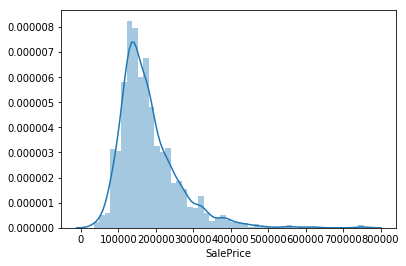

In [230]:
# Using histogram to have a big picture of the overall house price distribution
sns.distplot(train['SalePrice'])

# skewness and kurtosis 偏度和峰值
print('Skewness: %f' % train['SalePrice'].skew()) #偏度为正，说明数据集中在左边
print('Kurtosis: %f' % train['SalePrice'].kurt()) #峰值为0，说明正态分布

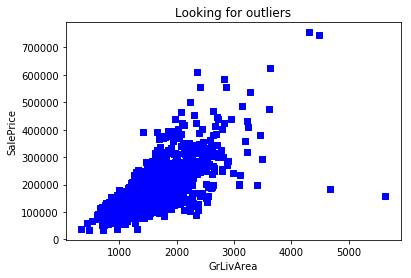

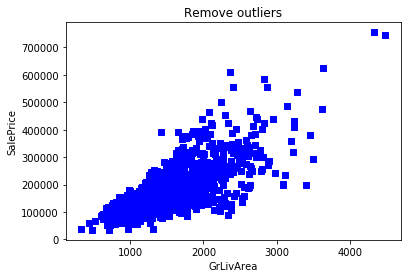

In [231]:
# Numerical features
# Scatter plot GrliveArea (Above grade (ground) living area square feet) and SalePrice
plt.scatter(train['GrLivArea'], train['SalePrice'], c='blue', marker='s')
plt.title('Looking for outliers')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

# Deleting points
train.sort_values(by='GrLivArea', ascending=False).head()[0:2]
train = train.drop(523)
train = train.drop(1298)

# Scatter plot for removing outliers
plt.scatter(train['GrLivArea'], train['SalePrice'], c='blue', marker='s')
plt.title('Remove outliers')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [232]:
# log transform the target for official scoring
# 在数据预处理的时候可以对偏度比较大的数据用log1p函数进行转化，使其更加服从高斯分布
# 此步处理可能会对我们后续的分类得到一个更好的结果
# log1p 即 ln(x+1)
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

In [233]:
train_desc = pd.DataFrame(train.describe().T)
train_desc
train_desc.loc[train_desc['count']!=1458]

,count,mean,std,min,25%,50%,75%,max
LotFrontage,1199.000,69.797,23.203,21.000,59.000,69.000,80.000,313.000
MasVnrArea,1450.000,102.754,179.442,0.000,0.000,0.000,164.750,1600.000
GarageYrBlt,1377.000,1978.464,24.683,1900.000,1961.000,1980.000,2002.000,2010.000


In [234]:
# check Alley NA total qty and fill NA with 'None', means 'no alley access'
train[train.loc[:,'Alley'].isnull()].shape
train.loc[:,'Alley'] = train.loc[:,'Alley'].fillna('None')
# fill NA with 'No', means 'no basement'
train.loc[:,'BsmtQual'] = train.loc[:,'BsmtQual'].fillna('No')
train.loc[:,'BsmtCond'] = train.loc[:,'BsmtCond'].fillna('No')
train.loc[:,'BsmtExposure'] = train.loc[:,'BsmtExposure'].fillna('No')
train.loc[:,'BsmtFinType1'] = train.loc[:,'BsmtFinType1'].fillna('No')
train.loc[:,'BsmtFinType2'] = train.loc[:,'BsmtFinType1'].fillna('No')
# fill NA with 'No', means 'no fence'
train.loc[:,'Fence'] = train.loc[:,'Fence'].fillna('No')
# fill NA with 'No', means 'no fireplace'
train.loc[:,'FireplaceQu'] = train.loc[:'FireplaceQu'].fillna('No')
# fill NA with 'No', means 'no garage'
train.loc[:,'GarageType'] = train.loc[:,'GarageType'].fillna('No')
train.loc[:,'GarageFinish'] = train.loc[:,'GarageFinish'].fillna('No')
train.loc[:,'GarageQual'] = train.loc[:,'GarageQual'].fillna('No')
train.loc[:,'GarageCond'] = train.loc[:,'GarageCond'].fillna('No')
# fill NA with 0, means 'no log frontage'
train.loc[:,'LotFrontage'] = train.loc[:,'LotFrontage'].fillna(0)
# fill NA with 'None', means 'no venner'
train.loc[:,'MasVnrType'] = train.loc[:,'MasVnrType'].fillna('None')
train.loc[:,'MasVnrArea'] = train.loc[:,'MasVnrArea'].fillna(0)
# fill NA with 'No', means 'no misc feature'
train.loc[:,'MiscFeature'] = train.loc[:,'MiscFeature'].fillna('No')
# fill NA with 'No', means 'no pool'
train.loc[:,'PoolQC'] = train.loc[:,'PoolQC'].fillna('No')


#train[train.loc[:,'WoodDeckSF'].isnull()].shape  #use this code to check each column's 'NAN' qty

In [235]:
# Some numerical features are actually really categories
train = train.replace({'MSSubClass':{20:'SC20',30:'SC30',40:'SC40',45:'SC45',
                                    50:'SC50',60:'SC60',70:'SC70',80:'SC80',
                                    85:'SC85',90:'SC90',120:'SC120',150:'SC150',
                                    180:'SC180',190:'SC190'},
                      'MoSold':{1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',
                               6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',
                               11:'Nov',12:'Dec'}})


In [236]:
# Encode some categorial features as ordered numbers when there is information 
# in the order
train = train.replace({'Alley':{'Grvl':1,'Pave':2},
                      'BsmtQual':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'BsmtCond':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'BsmtExposure':{'No':0,'Mn':1,'Av':2,'Gd':3},
                      'BsmtFinType1':{'No':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,
                                     'ALQ':5,'GLQ':6},
                      'BsmtFinType2':{'No':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,
                                     'ALQ':5,'GLQ':6},
                      'ExterQual':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'ExterCond':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'FireplaceQu':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'Functional':{'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,'Mod':5,
                                   'Min2':6,'Min1':7,'Typ':8},
                      'GarageCond':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'GarageQual':{'No':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'HeatingQC':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'KitchenQual':{'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                      'LandSlope':{'Sev':1,'Mod':2,'Gtl':3},
                      'LotShape':{'IR3':1,'IR2':2,'IR3':1,'Reg':4},
                       'PavedDrive':{'N':0,'P':1,'Y':2},
                       'PoolQC':{'No':0,'Fa':1,'TA':2,'Gd':3,'Ex':4},
                       'Street':{'Grvl':0,'Pave':2},
                       'Utilities':{'ELO':1,'NoSeWa':2,'NoSewr':3,'AllPub':4},
                      })

In [237]:
# Create new features
# 1. Simplifications of existing features
train['SimplOverallQual'] = train['OverallQual'].replace({1:1,2:1,3:1, #bad
                                                          4:2,5:2,6:2, #ave
                                                          7:3,8:3,9:3,10:3 #good
                                                         })
train['SimplOverallCond'] = train['OverallCond'].replace({1:1,2:1,3:1, #bad
                                                          4:2,5:2,6:2, #ave
                                                          7:3,8:3,9:3,10:3 #good
                                                         })
train['SimplPoolQC'] = train['PoolQC'].replace({1:1,2:1, #ave
                                                3:2,4:2 #good
                                               })
train['SimplGarageCond'] = train['GarageCond'].replace({1:1, #bad
                                                        2:1,3:1, #ave
                                                        4:2,5:2 #good
                                                       })
train['SimplGarageQual'] = train['GarageQual'].replace({1:1, #bad
                                                        2:1,3:1, #ave
                                                        4:2,5:2 #good
                                                       })
train['SimplFireplaceQu'] = train['FireplaceQu'].replace({1:1, #bad
                                                          2:1,3:1, #ave
                                                          4:2,5:2 #good
                                                         })
train['SimplFunctional'] = train['Functional'].replace({1:1,2:1, #bad
                                                      3:2,4:2, #major
                                                      5:3,6:3,7:3, #minor
                                                      8:4 #typlical
                                                     })
train['SimplKitchenQual'] = train['KitchenQual'].replace({1:1, #bad
                                                          2:1,3:1, #ave
                                                          4:2,5:2 #good
                                                         })
train['SimplHeatingQC'] = train['HeatingQC'].replace({1:1, #bad
                                                      2:1,3:1, #ave
                                                      4:2,5:2 #good
                                                     })
train['SimplBsmtFinType1'] = train['BsmtFinType1'].replace({1:1, #unfinished
                                                            2:1,3:1, #rec room
                                                            4:2,5:2,6:2 #living quarters
                                                           })
train['SimplBsmtFinType2'] = train['BsmtFinType2'].replace({1:1, #unfinished
                                                            2:1,3:1, #rec room
                                                            4:2,5:2,6:2 #living quarters
                                                           })
train['SimplBsmtCond'] = train['BsmtCond'].replace({1:1, #bad
                                                  2:1,3:1, #ave
                                                  4:2,5:2 #good
                                                 })
train['SimplBsmtQual'] = train['BsmtQual'].replace({1:1, #bad
                                                    2:1,3:1, #ave
                                                    4:2, 5:2 #good
                                                   })
train['SimplExterCond'] = train['ExterCond'].replace({1:1, #bad
                                                      2:1,3:1, #ave
                                                      4:2,5:2 #good
                                                     })
train['SimplExterQual'] = train['ExterQual'].replace({1:1, #bad
                                                      2:1,3:1, #ave
                                                      4:2,5:2 #good
                                                     })
                                                
            

In [238]:
# 2. Combinations of existing features
# Overall quality of the house
train['OverallGrade'] = train['OverallQual'] * train['OverallCond']
# Overall quality of the garage
train['GarageGrade'] = train['GarageQual'] * train['GarageCond']
# Overall quality of the exterior
train['ExterGrade'] = train['ExterQual'] * train['ExterCond']
# Overall kitchen score
train['KitchenScore'] = train['KitchenAbvGr'] * train['KitchenQual']
# Overall fireplace score
train['FireplaceScore'] = train['Fireplaces'] * train['FireplaceQu']
# Overall garage score
train['GarageScore'] = train['GarageArea'] * train['GarageQual']
# Overall pool score
train['PoolScore'] = train['PoolArea'] * train['PoolQC']

# Simplified overall quality of the house
train['SimplOverallGrade'] = train['SimplOverallQual'] * train['SimplOverallCond']
# Simplified overall quality of the exterior
train['SimplExterGrade'] = train['SimplExterQual'] * train['SimplExterCond']
# Simplified overall pool score
train['SimplPoolScore'] = train['PoolArea'] * train['SimplPoolQC']
# Simplified overall garage score
train['SimplGarageScore'] = train['GarageArea'] * train['SimplGarageQual']
# Simplified overall fireplace score
train['SimplFireplaceScore'] = train['Fireplaces'] * train['SimplFireplaceQu']
# Simplified overall kitchen score
train['SimplKitchenScore'] = train['KitchenAbvGr'] * train['SimplKitchenQual']
# Total number of bathrooms
train['TotalBath'] = train['BsmtFullBath'] + (0.5*train['BsmtHalfBath']) +\
                     train['FullBath'] + (0.5*train['HalfBath'])
# Total SF for house (include basement)
train['AllSF'] = train['GrLivArea'] + train['TotalBsmtSF']
# Total SF for 1st+2nd floors
train['AllFlrsSF'] = train['1stFlrSF'] + train['2ndFlrSF']
# Total SF for porch
train['AllPorchSF'] = train['OpenPorchSF'] + train['EnclosedPorch'] +\
                      train['3SsnPorch'] + train['ScreenPorch']
# Has masonry veneer or not
train['HasMasVnr'] = train['MasVnrType'].replace({'BrkCmn':1,'BrkFace':1,'CBlock':1,
                                                  'Stone':1,'None':0})
# House completed before sale or not
train['BoughtOffPlan'] = train['SaleCondition'].replace({'Abnorml':0,'Alloca':0,
                                                         'AdjLand':0,'Family':0,
                                                         'Normal':0,'Partial':1})


In [239]:
# Find most important features relative to target
print('Find most important features relative to target')
corr = train.corr()
corr.sort_values(['SalePrice'],ascending=False,inplace=True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice            1.000
OverallQual          0.821
AllSF                0.821
AllFlrsSF            0.735
GrLivArea            0.725
SimplOverallQual     0.707
ExterQual            0.682
GarageCars           0.681
TotalBath            0.677
KitchenQual          0.670
GarageScore          0.658
GarageArea           0.656
TotalBsmtSF          0.648
SimplExterQual       0.635
SimplGarageScore     0.631
1stFlrSF             0.621
BsmtQual             0.617
SimplKitchenQual     0.609
OverallGrade         0.608
FullBath             0.596
SimplBsmtQual        0.592
ExterGrade           0.588
YearBuilt            0.587
YearRemodAdd         0.566
FireplaceQu          0.547
GarageYrBlt          0.542
TotRmsAbvGrd         0.538
SimplOverallGrade    0.525
FireplaceScore       0.524
SimplKitchenScore    0.523
                     ...  
LotArea              0.261
BsmtFullBath         0.237
BsmtUnfSF            0.222
BedroomAbvGr         0.209
SimplBs

In [240]:
# Create new features
# 3. Polynomials on the top10 existing features
train['OverallQual-s2'] = train['OverallQual']**2
train['OverallQual-s3'] = train['OverallQual']**3
train['OverallQual-Sq'] = np.sqrt(train['OverallQual'])
train['AllSF-2'] = train['AllSF']**2
train['AllSF-3'] = train['AllSF']**3
train['AllSF-Sq'] = np.sqrt(train['AllSF'])
train['AllFlrsSF-2'] = train['AllFlrsSF']**2
train['AllFlrsSF-3'] = train['AllFlrsSF']**3
train['AllFlrsSF-Sq'] = np.sqrt(train['AllFlrsSF'])
train['GrLivArea-2'] = train['GrLivArea']**2
train['GrLivArea-3'] = train['GrLivArea']**3
train['GrLivArea-Sq'] = np.sqrt(train['GrLivArea'])
train['SimplOverallQual-s2'] = train['SimplOverallQual']**2
train['SimplOverallQual-s3'] = train['SimplOverallQual']**3
train['SimplOverallQual-Sq'] = np.sqrt(train['SimplOverallQual'])
train['ExterQual-2'] = train['ExterQual']**2
train['ExterQual-3'] = train['ExterQual']**3
train['ExterQual-Sq'] = np.sqrt(train['ExterQual'])
train['GarageCars-2'] = train['GarageCars']**2
train['GarageCars-3'] = train['GarageCars']**3
train['GarageCars-Sq'] = np.sqrt(train['GarageCars'])
train['TotalBath-2'] = train['TotalBath']**2
train['TotalBath-3'] = train['TotalBath']**3
train['TotalBath-Sq'] = np.sqrt(train['TotalBath'])
train['KitchenQual-2'] = train['KitchenQual']**2
train['KitchenQual-3'] = train['KitchenQual']**3
train['KitchenQual-Sq'] = np.sqrt(train['KitchenQual'])
train['GarageScore-2'] = train['GarageScore']**2
train['GarageScore-3'] = train['GarageScore']**3
train['GarageScore-Sq'] = np.sqrt(train['GarageScore'])

In [241]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = train.select_dtypes(include=['object']).columns
numerical_features = train.select_dtypes(exclude=['object']).columns
numerical_features = numerical_features.drop('SalePrice')

print('Numerical features:'+ str(len(numerical_features)))
print('Categorical features:'+ str(len(categorical_features)))

train_num = train[numerical_features]
train_cat = train[categorical_features]

Numerical features:116
Categorical features:27


In [242]:
# Handle remaining missing values for numerical features by using median 
# as replacement
print('NAs for numerical features in train: '+str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print('Remaining NAs for numerical features in train: '+str(train_num.isnull().values.sum()))

NAs for numerical features in train: 81
Remaining NAs for numerical features in train: 0


In [243]:
# log transform of the skewed numerical features to lessen impact of outliers
# As a general rule of thumb, a skewness with an absolute value >0.5 is
# considered at least moderately skewed
# log1p(x) = ln(x)
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness)>0.5]
print(str(skewness.shape[0]) + ' skewed numerical features to log transform')
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

86 skewed numerical features to log transform


In [244]:
# train_num after skewed
train_num[skewed_features].head()

,LotArea,Street,Utilities,LandSlope,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,GarageCars-2,GarageCars-3,GarageCars-Sq,TotalBath-2,TotalBath-3,KitchenQual-2,KitchenQual-3,GarageScore-2,GarageScore-3,GarageScore-Sq
0,9.042,1.099,1.609,1.386,1.792,7.603,7.603,5.283,1.609,1.386,...,1.609,2.197,0.881,2.584,3.781,2.833,4.174,14.810,22.215,3.727
1,9.170,1.099,1.609,1.386,2.197,7.589,7.589,0.000,1.386,1.386,...,1.609,2.197,0.881,1.981,2.811,2.303,3.332,14.460,21.690,3.641
2,9.328,1.099,1.609,1.386,1.792,7.602,7.602,5.094,1.609,1.386,...,1.609,2.197,0.881,2.584,3.781,2.833,4.174,15.018,22.526,3.778
3,9.164,1.099,1.609,1.386,1.792,7.558,7.586,0.000,1.386,1.386,...,2.303,3.332,1.005,1.609,2.197,2.833,4.174,15.126,22.690,3.804
4,9.565,1.099,1.609,1.386,1.792,7.601,7.601,5.861,1.609,1.386,...,2.303,3.332,1.005,2.584,3.781,2.833,4.174,15.654,23.482,3.933


In [245]:
# Create dummy features for categarical values via one-hot encoding
print('NAs for categorical features in train: '+\
      str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print('Remaining NAs for categorical features in train: '+\
      str(train_cat.isnull().values.sum()))

NAs for categorical features in train: 1
Remaining NAs for categorical features in train: 0


In [246]:
# Join numerical and categorical features
train = pd.concat([train_num, train_cat], axis=1)
print('New number of features: ' + str(train.shape[1]))

# Partition the dataset in train + validation sets
x_train, x_test, y_train, y_test = train_test_split(train, y, test_size=0.3, 
                                                    random_state=0)
print('x_train: ' + str(x_train.shape))
print('x_test: ' + str(x_test.shape))
print('y_train: ' + str(y_train.shape))
print('y_test: ' + str(y_test.shape))

New number of features: 322
x_train: (1020, 322)
x_test: (438, 322)
y_train: (1020,)
y_test: (438,)


In [247]:
# Standardize numerical features
stdSc = StandardScaler()
x_train.loc[:,numerical_features] = stdSc.fit_transform(x_train.loc[:,numerical_features])
x_test.loc[:,numerical_features] = stdSc.transform(x_test.loc[:,numerical_features])

In [248]:
# Define error measure for official scoring: RMSE
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def rmse_cv_train(model):
    # 这里的scores都是负数，为什么均方误差会出现负数的情况呢？
    # 由于这里的mean_squared_error是一种损失函数，优化的目标的使其最小化。
    # 而分类准确率是一种奖励函数，优化的目标是使其最大化。
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring=scorer, cv=10))
    return(rmse)

def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model, x_test, y_test, scoring=scorer, cv=10))
    return(rmse)

RMSE on Training set:  24248881158.36106
RMSE on Test set:  55161335043.809425


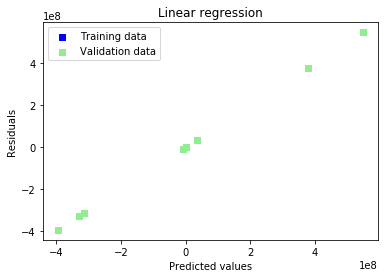

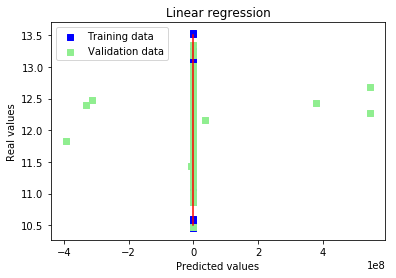

In [368]:
# Linear Regression
lr = LinearRegression()
lr.fit(x_train, y_train) 
# Look at predictions on training and validation set
print('RMSE on Training set: ', rmse_cv_train(lr).mean())
print('RMSE on Test set: ', rmse_cv_test(lr).mean())
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)
# Plot residuals
plt.scatter(y_train_pred, y_train_pred-y_train, c='blue', marker='s', label='Training data')
plt.scatter(y_test_pred, y_test_pred-y_test, c='lightgreen', marker='s', label='Validation data')
plt.title('Linear regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-5, xmax=13, color='red')
plt.show()
# Plot predictions
plt.scatter(y_train_pred, y_train, c='blue', marker='s', label='Training data')
plt.scatter(y_test_pred, y_test, c='lightgreen', marker='s', label='Validation data')
plt.title('Linear regression')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc='upper left')
plt.plot([10.5, 13.5],[10.5,13.5], c='red')
plt.show()

Best alpha:  30.0
Try again for more precision with alphas centerd around 30.0
Best alpha:  22.5
Ridge RMSE on Training set:  0.11306161624932753
Ridge RMSE on Test set:  0.12128738486453779


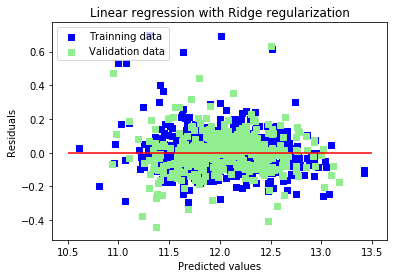

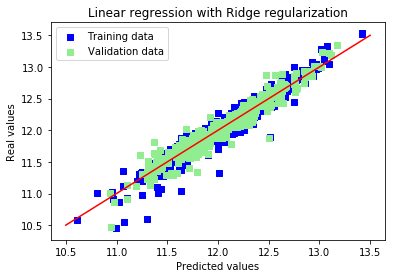

Ridge picked 316 features and eliminated the other 6 features 


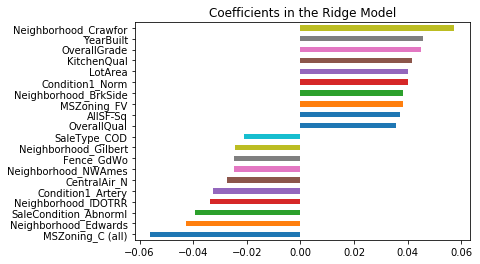

In [458]:
# 2. Linear regression with Ridge regularization (L2 Penalty)
ridge = RidgeCV(alphas=[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10 ,30, 60])
ridge.fit(x_train, y_train)
alpha = ridge.alpha_
print('Best alpha: ', alpha)
print('Try again for more precision with alphas centerd around '+str(alpha))
ridge = RidgeCV(alphas=[alpha*0.6, alpha*0.65, alpha*0.7, alpha*0.75, alpha*0.8,
                        alpha*0.85, alpha*0.9, alpha*1.05, alpha*1.1, alpha*1.15,
                        alpha*1.2, alpha*1.25, alpha*1.3, alpha*1.35, alpha*1.4])
ridge.fit(x_train, y_train)
alpha = ridge.alpha_
print('Best alpha: ', alpha)

print('Ridge RMSE on Training set: ', rmse_cv_train(ridge).mean())
print('Ridge RMSE on Test set: ', rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(x_train)
y_test_rdg = ridge.predict(x_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg-y_train, c='blue', marker='s', label='Trainning data')
plt.scatter(y_test_rdg, y_test_rdg-y_test, c='lightgreen', marker='s', label='Validation data')
plt.title('Linear regression with Ridge regularization')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=10.5, xmax=13.5, color='red')
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c='blue', marker='s', label='Training data')
plt.scatter(y_test_rdg, y_test, c='lightgreen', marker='s', label='Validation data')
plt.title('Linear regression with Ridge regularization')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.legend(loc='upper left')
plt.plot([10.5,13.5],[10.5,13.5],c='red')
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = x_train.columns)
print('Ridge picked ' + str(sum(coefs !=0)) + ' features and eliminated the other '+\
      str(sum(coefs==0)) + ' features ')
imp_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
imp_coefs.plot(kind='barh')
plt.title('Coefficients in the Ridge Model')
plt.show()